In [1]:
# Gezinomi Rule-Based Classification & Potential Revenue Calculation

### Business Problem
# Gezinomi wants to create new level-based sales definitions (personas) 
# by using features like city, concept, and season. The goal is to:
# 1. Define new customer personas.
# 2. Segment these personas.

**Example:** How much revenue can an "All Inclusive" hotel in "Antalya" during "High Season" potentially generate?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 500)

print("Libraries imported successfully.")

Object `generate` not found.
Libraries imported successfully.


In [2]:
# Load the dataset
# Note: Ensure the path is correct for your Kaggle input
df = pd.read_excel("/kaggle/input/datasets/bsrsrc/gezinomi/miuul_gezinomi.xlsx")

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
   
check_df(df)

##################### Shape #####################
(59164, 9)
##################### Types #####################
SaleId                         int64
SaleDate              datetime64[ns]
CheckInDate           datetime64[ns]
Price                        float64
ConceptName                   object
SaleCityName                  object
CInDay                        object
SaleCheckInDayDiff             int64
Seasons                       object
dtype: object
##################### Head #####################
   SaleId   SaleDate CheckInDate  Price     ConceptName SaleCityName    CInDay  SaleCheckInDayDiff Seasons
0  415122 2022-12-03  2022-12-03  79.30    Herşey Dahil      Antalya  Saturday                   0     Low
1  415103 2022-12-03  2022-12-03  45.97  Yarım Pansiyon      Antalya  Saturday                   0     Low
2  404034 2022-09-12  2022-09-13  77.84    Herşey Dahil      Antalya   Tuesday                   1    High
3  415094 2022-12-03  2022-12-10 222.71  Yarım Pansiyon        İz

City-based revenue sum:
                  Price
SaleCityName           
Antalya      2041911.10
Aydın         573296.01
Diğer         154572.29
Girne          27065.03
Muğla         665842.21
İzmir         165934.83

Concept-based price averages:
                Price
ConceptName          
Herşey Dahil    62.67
Oda + Kahvaltı  50.25
Yarım Pansiyon  49.03


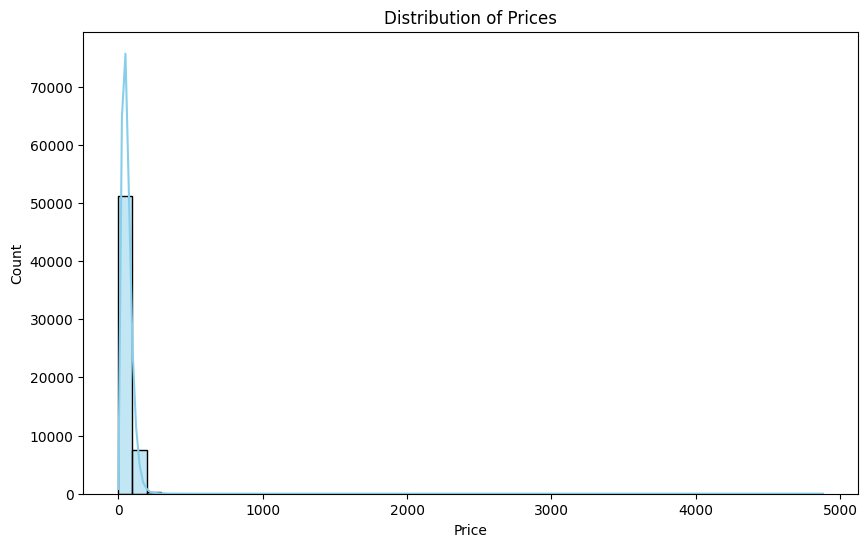

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Analysis of Categorical Variables
print("City-based revenue sum:")
print(df.groupby("SaleCityName").agg({"Price": "sum"}))

print("\nConcept-based price averages:")
print(df.groupby("ConceptName").agg({"Price": "mean"}))

# Visualization of Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Prices')
plt.show()

In [4]:
# Categorizing 'SaleCheckInDayDiff' to see early booking impact
bins = [-1, 7, 30, 90, df["SaleCheckInDayDiff"].max()]
labels = ["Last Minuters", "Potential Early Bookers", "Early Bookers", "Very Early Bookers"]

df["EB_Score"] = pd.cut(df["SaleCheckInDayDiff"], bins, labels=labels)

print("Early Booking Score Distribution:")
print(df["EB_Score"].value_counts())

Early Booking Score Distribution:
EB_Score
Last Minuters              26564
Potential Early Bookers    16621
Early Bookers               9184
Very Early Bookers          6795
Name: count, dtype: int64


In [5]:
# Grouping by City, Concept, Season and getting average prices
agg_df = df.groupby(["SaleCityName", "ConceptName", "Seasons"]).agg({"Price": "mean"}).sort_values("Price", ascending=False)
agg_df.reset_index(inplace=True)

# Creating the persona variable: 'sales_level_based'
# Standardizing: Uppercase and underscores
agg_df["sales_level_based"] = [row[0].upper() + "_" + row[1].upper() + "_" + row[2].upper() for row in agg_df.values]

# Keep only necessary columns
agg_df = agg_df[["sales_level_based", "Price"]]
agg_df.head()

,sales_level_based,Price
0,GIRNE_HERŞEY DAHIL_HIGH,103.94
1,GIRNE_HERŞEY DAHIL_LOW,90.94
2,İZMIR_YARIM PANSIYON_HIGH,87.66
3,DIĞER_HERŞEY DAHIL_LOW,87.31
4,DIĞER_HERŞEY DAHIL_HIGH,83.79


Segment Statistics:
        Price                    
         mean    max    sum count
SEGMENT                          
D       33.37  39.48 300.30     9
C       44.89  54.14 403.99     9
B       60.27  64.92 542.47     9
A       82.47 103.94 742.21     9


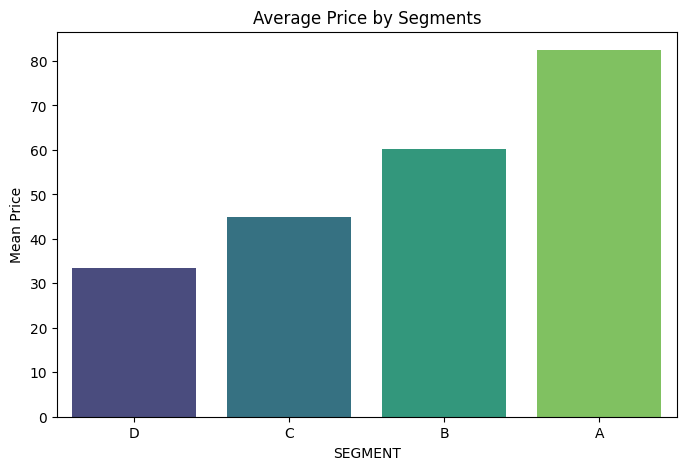

In [6]:
# Dividing personas into 4 segments (A, B, C, D) based on Price
agg_df["SEGMENT"] = pd.qcut(agg_df["Price"], 4, labels=["D", "C", "B", "A"])

print("Segment Statistics:")
summary = agg_df.groupby("SEGMENT", observed=False).agg({"Price": ["mean", "max", "sum", "count"]})
print(summary)

# Visualizing Segments
plt.figure(figsize=(8, 5))
sns.barplot(x=summary.index, y=summary[('Price', 'mean')], hue=summary.index, palette="viridis", legend=False)
plt.title('Average Price by Segments')
plt.ylabel('Mean Price')
plt.show()

In [7]:
def predict_revenue(new_user):
    """
    Predicts the expected revenue and segment for a given customer persona.
    Input format: 'CITY_CONCEPT_SEASON'
    """
    new_user = new_user.upper()
    res = agg_df[agg_df["sales_level_based"] == new_user]
    
    if not res.empty:
        print(f"--- Results for: {new_user} ---")
        print(f"Segment: {res['SEGMENT'].values[0]}")
        print(f"Estimated Average Revenue: {res['Price'].values[0]:.2f}")
    else:
        print(f"Persona '{new_user}' not found in records.")

# Case 1
predict_revenue("ANTALYA_HERŞEY DAHIL_HIGH")

# Case 2
predict_revenue("GIRNE_YARIM PANSIYON_LOW")

--- Results for: ANTALYA_HERŞEY DAHIL_HIGH ---
Segment: B
Estimated Average Revenue: 64.92
--- Results for: GIRNE_YARIM PANSIYON_LOW ---
Segment: C
Estimated Average Revenue: 48.58
